In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import fourier
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq

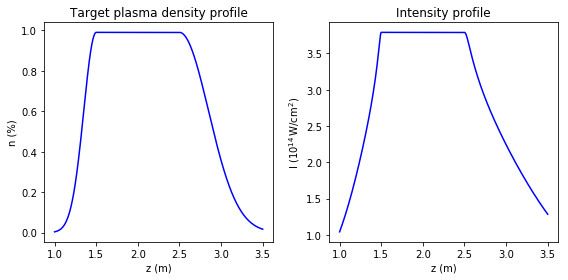

In [2]:
# First test of a tailored plasma profile (ray approximation)
# Temporal pulse shape, assume 50fs duration
def f(I, t):
    return ionization.gaussian_field(I, t, .375, 50).real
I = np.linspace(0, 10, 1000)
t = np.linspace(-100, 100, 1000)
# Diatomic hydrogen - intensity from ionization fraction
g = adk.intensity_func(15.426, I, t, f, 1)

# Create the z grid
NEnt = 500
NBody = 1000
NExit = 1000
Nz = NEnt + NBody + NExit
d1 = 1e6
d2 = 1.5e6
d3 = 2.5e6
d4 = 3.5e6
zEnt = np.linspace(d1, d2, NEnt, False)
zBody = np.linspace(d2, d3, NBody, False)
zExit = np.linspace(d3, d4, NExit)
z = np.concatenate((zEnt, zBody, zExit))

R=10e3
# Create the params for reference
params = {'Nx' : 2**10,
          'Ny' : 2**10,
          'Nz' : 2**8,
          'X' : R*3,
          'Y' : R*3,
          'Z' : d4-d1,
          'z0' : d1,
          'lam' : 0.8,
          'n' : 1.0,
          # Params for the E-field function
          'R' : R,
          }

# Entrance and exit ramps
sigmaEnt = 150e3
sigmaExit = 350e3
nEnt = 0.99*np.exp(-(zEnt-d2)**2/(2*sigmaEnt**2))
nBody = np.zeros(NBody) + 0.99
nExit = 0.99*np.exp(-(zExit-d3)**2/(2*sigmaExit**2))
n = np.concatenate((nEnt, nBody, nExit))

# Calculate the desired intensity profile
I = g(n)

# Plot initial conditions
plt.figure(figsize=(8,4))
# Ionization fraction
plt.subplot(121)
plt.plot(z/1e6, n, 'b-')
plt.title('Target plasma density profile')
plt.xlabel('z (m)')
plt.ylabel('n (%)')
# Intensity profile
plt.subplot(122)
plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')

plt.tight_layout()
plt.show()

In [52]:
import numpy as np
from scipy import integrate
from ionization import ionization
from scipy.interpolate import interp1d
from numpy.fft import fft, ifft, fftfreq, ifftshift

def phase_function(I0, r, I, z, lam, M):
    N = np.size(r)
    Nz = np.size(z)
    Z0 = z[1]
    Z = z[Nz-1]
    R = r[N-1]
    E0 = ionization.field_from_intensity(I0)
    Ez = ionization.field_from_intensity(I)
    # Create interpolating functions
    E0 = interp1d(r, E0)
    Ez = interp1d(z, Ez)
    # Effective coordinate and frequency of the Fourier transform
    F = z_to_f(Z0, lam)
    f0 = z_to_f(Z, lam)
    f = np.linspace(-F, F, N, False)
    f = ifftshift(f)
    chi = np.linspace(0, R**2, N)
    # Find the functions that are a Fourier-real space pair
    eta = E0(np.sqrt(chi))
    eps = np.zeros(N, dtype=np.complex)
    sel = f > f0
    eps[sel] = 1j*2*np.pi * Ez(f_to_z(abs(f[sel]), lam)) / f[sel]
    plt.plot(abs(eps))
    plt.show()
    # Scale the frequency space function to satisfy Parseval's Theorem
    scale = integrate.trapz(abs(eps)**2, f) / integrate.trapz(abs(eta)**2, chi)
    eta = eta * scale
    plt.plot(chi, abs(eta))
    plt.show()
    # Gerchberg-Saxton algorithm
    # TODO add in error criterion instead of iteration number
    A = fft(eps);
    for i in range(0, M):
        B = abs(eta) * np.exp(1j*np.angle(A))
        C = ifft(B)
        D = abs(eps) * np.exp(1j*np.angle(C))
        A = fft(D)
    phi = np.unwrap(np.angle(A))
    # Return in r coordinates
    return np.sqrt(chi), phi


def f_to_z(f, lam):
    return 2*np.pi**2/(lam*f)


def z_to_f(z, lam):
    return 2*np.pi**2/(lam*z)

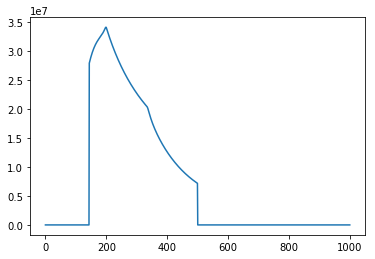

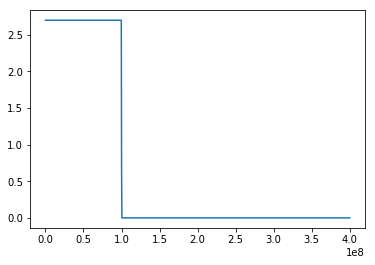

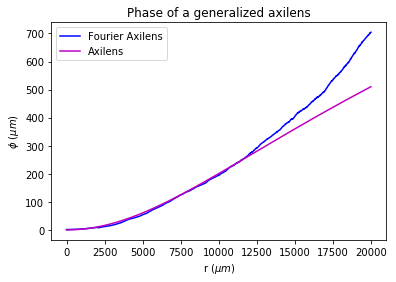

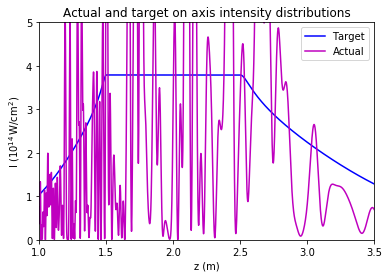

In [61]:
N = 1000
R = params['R']
r = np.linspace(0, 2*R, N)
I0 = np.zeros(np.shape(r))
I0[r < R] = 1.0

r, phi = phase_function(I0, r, I, z, params['lam'], 100)

phi = phi/2
f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

k = 2*np.pi/params['lam']
plt.plot(r, abs(phi),'b-',r, abs(k*phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Fourier Axilens','Axilens'])
plt.show()

params['E0'] = ionization.field_from_intensity(I0)
# Fresnel propagation
Ediff = laser.fresnel_axis(ionization.field_from_intensity(I0)*np.exp(1j*phi), r, z, params['lam'])
Idiff = abs(Ediff)**2
# Shift everything by the average
Itot = integrate.simps(I)
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)


plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.xlim([1.0, 3.5])
plt.ylim([0, 5])
plt.show()

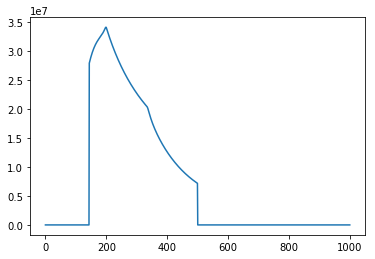

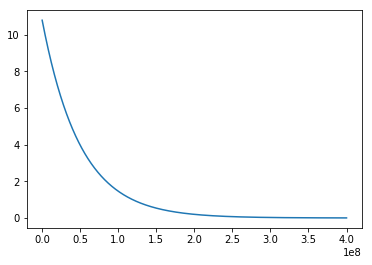

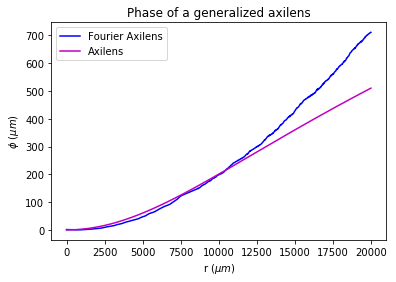

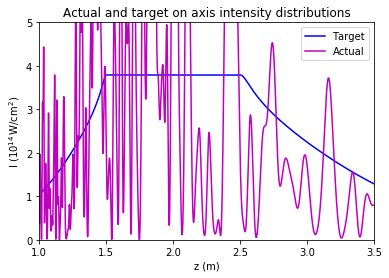

In [62]:
N = 1000
R = params['R']
R0 = 5e3
r = np.linspace(0, 2*R, N)
I0 = np.zeros(np.shape(r))
I0 = np.exp(-r**2/R0**2)

r, phi = phase_function(I0, r, I, z, params['lam'], 100)

phi = phi/2
f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

k = 2*np.pi/params['lam']
plt.plot(r, abs(phi),'b-',r, abs(k*phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Fourier Axilens','Axilens'])
plt.show()

params['E0'] = ionization.field_from_intensity(I0)
# Fresnel propagation
Ediff = laser.fresnel_axis(ionization.field_from_intensity(I0)*np.exp(1j*phi), r, z, params['lam'])
Idiff = abs(Ediff)**2
# Shift everything by the average
Itot = integrate.simps(I)
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)


plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.xlim([1.0, 3.5])
plt.ylim([0, 5])
plt.show()

In [ ]:
# Attempt with 